# Volatility

**Introduction to Quantitative Methods in Finance**

**The Erdös Institute**

## Understanding Volatility

Volatility is a critical concept in the world of finance. It refers to the annualized degree of variation in the price or returns of a financial asset over time. In simple terms, it measures how much an asset's value tends to fluctuate. Understanding and quantifying volatility is crucial for risk assessment, trading strategies, and financial modeling.

## The Role of Volatility in Value at Risk (VaR)

Value at Risk (VaR) is a quantitative tool used to estimate the potential losses in a portfolio or investment over a specified time horizon and confidence level. Volatility plays a central role in VaR calculations because it helps us gauge the range of possible outcomes and the associated risk.


## Calculating Volatility and VaR

There are various methods to calculate volatility, our baseline measurement will be historical volatility. This method involves analyzing past price or return data to estimate how much an asset's value has typically moved in the past. Historical volatility in these notebooks represents the annualized standard deviation of log-returns over a given time period. The higher the standard deviation, the greater the volatility. 

A more common approach to modeling volatility and VaR often employed in quantitative finance is **Generalized Autoregressive Conditional Heteroskedasticity (GARCH)** modeling. Unlike simple historical volatility, which provides a static estimate of past volatility, GARCH models offer a dynamic and time-varying measure of volatility. GARCH models take into account the fact that financial markets exhibit changing levels of volatility over time.

GARCH models consider not only past returns but also past volatility in their calculations. This means that recent periods of high volatility will have a more significant impact on the estimated volatility compared to periods of relative calm. This dynamic aspect of GARCH makes it particularly useful for capturing the inherent volatility clustering observed in financial markets. By modeling volatility in this way, analysts can obtain more accurate estimates of risk and better understand how market conditions change.

In addition to GARCH models, standard machine learning algorithms like **Random Forest** and **Support Vector Machines (SVMs)** can be employed to compute **Value at Risk (VaR)**. These algorithms can provide an alternative approach to estimating VaR by leveraging historical price and return data along with other relevant features.

In [ ]:
#You may need to use a previous version of numpy for code to work

pip --install numpy<2

In [3]:
#Import packages

import yfinance as yf
import datetime as dt
from IPython.display import Markdown as md
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from scipy.stats import anderson, zscore, norm
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
sns.set(style="darkgrid", palette = 'bright')
from statsmodels.stats.diagnostic import acorr_ljungbox

[*********************100%%**********************]  1 of 1 completed


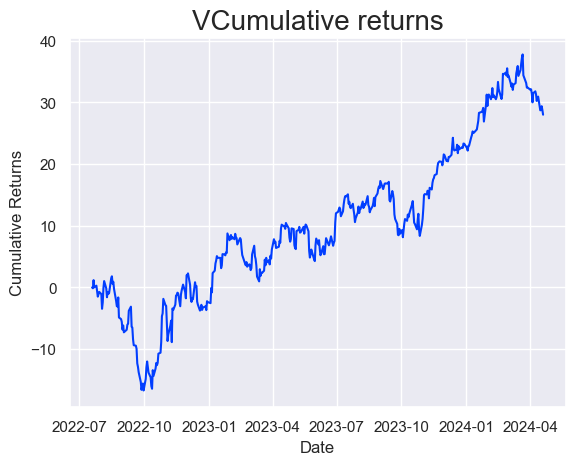

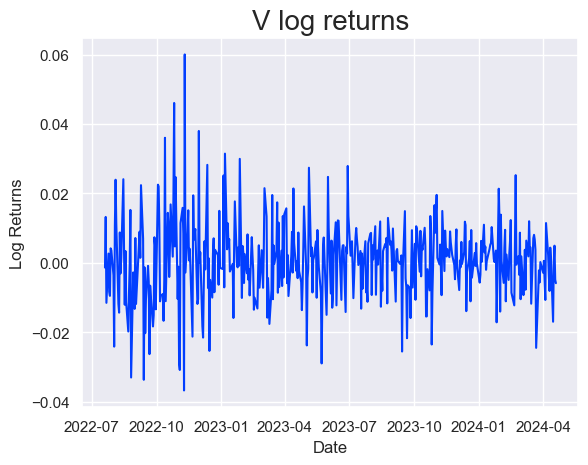

In [29]:
# Define the ticker symbol
ticker =  'V' #Ticker

# Define the date range
start_date = dt.datetime.today() - dt.timedelta(days = 2*365)
end_date = dt.datetime.today() - dt.timedelta(days = 90)

# Retrieve the stock data from yfinance
stock_data = yf.download(ticker, start=start_date, end=end_date)
stock_data['log returns'] = np.log(stock_data['Adj Close']/stock_data['Adj Close'].shift(1))
stock_data['returns'] = stock_data['Adj Close']/stock_data['Adj Close'].shift(1)-1
returns = stock_data['returns'].copy()
returns = returns.dropna()
log_returns = stock_data['log returns'].copy()
log_returns = log_returns.dropna()

# Data Visualization
plt.plot((stock_data['Adj Close']/stock_data['Adj Close'].iloc[0]-1)*100, label=ticker)
plt.title(''.join([ticker, 'Cumulative returns']), size = 20)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

plt.plot(returns)
plt.title(''.join([ticker,' log returns']), size = 20)
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.show()

### Volatility estimate: One Month Rolling Volatility  <a id='baseline'>

In financial analysis, volatility is a key metric that measures the variation in the price or returns of a financial asset over time. A baseline approach to analyze volatility is by calculating rolling volatility measurements, which provide insights into the long-term historical stability and fluctuations of an asset's performance. In this context, we will focus on calculating one month rolling volatility for a stock's returns.

**Steps to Calculate One Month Rolling Volatility**

1. **Data Preparation**: Collect the historical daily price data for the stock. Ensure that the data covers a sufficient period to compute the rolling volatility over 22 trading days.

2. **Return Calculation**: Calculate the daily returns of the stock. Daily returns are typically computed as the percentage change in the stock's price from one day to the next:

3. **Calculate Rolling Volatility**: Calculate the rolling volatility over one month (21 trading days). This involves computing the standard deviation of the returns within a rolling window of 21 days.The mean of these values represents the average daily volatility of the stock. Rescaling by $\displaystyle \sqrt{252}$ provides the estimated (yearly) volatility of the stock's returns and can be used as a baseline for risk management and option pricing.

In [18]:
# Calculate the 30-day rolling standard deviation of returns and drop NaN values
moving_average_30d = stock_data['log returns'].rolling(window=21).std().dropna()

# Calculate the annualized volatility using the mean of the rolling standard deviations
yearly_volatility = moving_average_30d.mean()*np.sqrt(252)

# Print the result
print(f'The 30-day moving average volatility of {ticker} is {round(np.mean(yearly_volatility * 100), 2)}%')


The 30-day moving average volatility of V is 17.49%


**Warning** The 30-day moving average volatility of returns is a crude measurement of volatility. 

## GARCH  <a id='GARCH'>
    
Returns in financial markets often exhibit correlation with their previous values, indicating a degree of dependence over time. This temporal correlation is a fundamental aspect of financial data and can significantly impact risk assessment, option pricing, and portfolio management strategies. The GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model proves to be an invaluable tool in addressing this phenomenon. By capturing the autocorrelation of volatility through its volatility model, GARCH acknowledges the intricate relationship between historical returns and their subsequent behavior. This acknowledgment is especially relevant in assessing risk and pricing financial instruments such as options, as it accommodates the ever-changing nature of volatility, which is essential for accurately modeling and understanding market dynamics. GARCH's ability to incorporate volatility persistence enhances its practicality in evaluating and predicting financial asset behavior, making it a staple in quantitative finance and risk management.
    
In line with the industry standard, we will proceed with using the GARCH(1,1) model to capture the volatility. More generally, one can model variance using a GARCH(p,q) model for different integer values for p and q. Higher values for p inform the model to consider a larger number of previous squared return to model high and low volatility clusters. Higher values of q inform the model to consider the variance of a larger number of previous returns to influence the predicted volatility. Autocorrelation charts provide visuals that can be used to bring awareness of autocorrelation and statistical tests, such as the Ljung-Box test, can be used to detect if autocorrelation is present at a desired level of statistical significance.

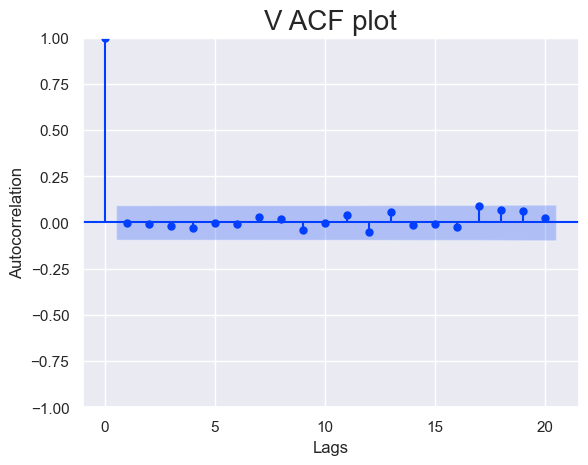

In [19]:
# Plot the autocorrelation function (ACF) plot
plot_acf(returns, lags=20)


plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title(''.join([ticker, ' ACF plot']), size = 20)
plt.show()

**GARCH Variants**

- In addition to the standard GARCH model, there are numerous variants that may be more suitable when evaluating various stocks and strategies. For example:
  - EGARCH (Exponential GARCH) accounts for asymmetric effects of positive and negative shocks on volatility.
  - GJR-GARCH (Generalized Autoregressive Conditional Heteroskedasticity with Skewness and Kurtosis) introduces additional parameters to model skewness and kurtosis in the return distribution.

**Estimating GARCH Parameters**

- GARCH(1,1) is an industry standard for predicting future volatility. However, modeling can be improved by adjusting the parameters of the model.
- Maximum Likelihood Estimation (MLE) is a techniqe to estimate parameter values that maximize the likelihood of the observed data, given the model assumptions, e.g. values are assumed to come from a normal distribution.

## GARCH Model Formula

The GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model is defined by the following formula:

$$
\sigma_t^2 = \omega + \sum_{i=1}^{p} \alpha_i \cdot \varepsilon_{t-i}^2 + \sum_{j=1}^{q} \beta_j \cdot \sigma_{t-j}^2
$$

Where:
- $\sigma_t^2$: Conditional variance or volatility at time $t$.
- $\omega$: Constant term, representing long-term average volatility.
- $\alpha_i$: Parameters for short-term impact of past squared returns.
- $\beta_j$: Parameters for long-term persistence of volatility.
- $p$ and $q$: Order parameters determining the number of past values considered.
- $\varepsilon_{t-i}$ is the residual error at time $t-i$.

### Parameters Explanation

1. **Omega (ω):**
   - Represents the baseline or long-term average volatility.
   - Higher ω means higher overall volatility.

2. **Alpha (α):**
   - Measures short-term impact of past returns on current volatility.
   - Larger α indicates quicker response to new information.

3. **Beta (β):**
   - Captures long-term persistence of volatility.
   - Larger β means past volatility strongly influences current volatility.


### GARCH(1,1) volatility forecasting example

Let's start with a GARCH(1,1) model of the stock's volatility. We will train the model on the spanned trading days, except the last $21$. We will then compare the model's performance with the realized volatility over the testing period.

The GARCH(1,1) line represents represents (annualized) daily volatility predictions that were modeled over the training period.


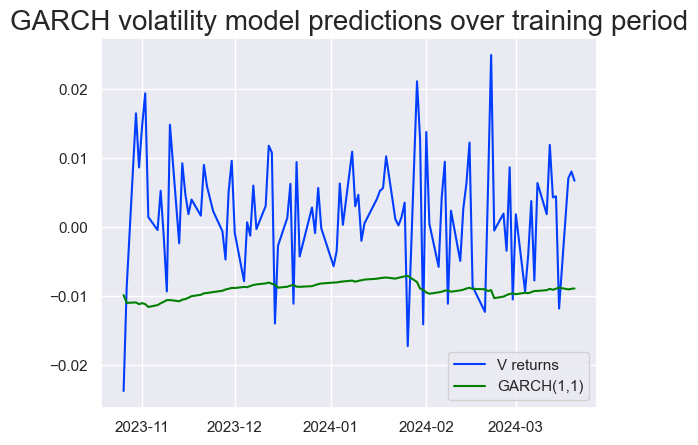

GARCH(1,1) forecasted volatility over testing period: 0.09102894464417667
-------
Realized volatility over testing period: 0.12543070743990645
-------
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            log returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -637.458
Distribution:                  Normal   AIC:                           1282.92
Method:            Maximum Likelihood   BIC:                           1299.08
                                        No. Observations:                  420
Date:                Thu, Jul 18 2024   Df Residuals:                      419
Time:                        13:33:02   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.

/var/folders/y9/h1gp0h4s6hj68gv7rdh9l6tm0000gq/T/ipykernel_92133/558438571.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  real_vol = testing_set.rolling(window = 21).std()[-1]*np.sqrt(252)


In [20]:
returns_data = stock_data['log returns'].dropna()

# Split Data into Training and Testing Sets
testing_days = 21



testing_set = returns_data[-testing_days:]
training_set = returns_data[:-testing_days]
training_set_scaled = 100*training_set #Multiplying by 100 makes the model run more accurately. Have to rescale outputs accordingly.

#Perform GARCH Modeling on the Training Set
garch_model = arch_model(training_set_scaled, vol='Garch', p=1, q=1)
results = garch_model.fit(disp='off')


# Calculate GARCH conditional volatility for the testing set
garch_volatility = results.conditional_volatility/100
projected_results = results.forecast(horizon = testing_days, reindex = 'False')

projected_results_variance = projected_results.variance.iloc[-1].values/100 #Rescale values
forecasted_vol = np.sqrt(projected_results_variance).mean()



#Plot model results
print('The GARCH(1,1) line represents represents (annualized) daily volatility predictions that were modeled over the training period.')
plt.plot(training_set.iloc[-100:], label = ''.join([ticker, ' returns']))
plt.plot(-garch_volatility.iloc[-100:],color = 'green', label = 'GARCH(1,1)')
plt.title('GARCH volatility model predictions over training period', size = 20)
plt.legend()
plt.show()


print(f'GARCH(1,1) forecasted volatility over testing period: {forecasted_vol}')
print('-------')
real_vol = testing_set.rolling(window = 21).std()[-1]*np.sqrt(252)
print(f'Realized volatility over testing period: {real_vol}')
print('-------')
print(results)


## Value at Risk (VaR)

Value at Risk (VaR) is a widely used risk management metric in finance that estimates the potential loss of an investment or portfolio over a given time horizon and at a certain confidence level. VaR provides a numerical measure of the maximum expected loss under normal market conditions.

### Interpretation

VaR is typically expressed as a negative value or loss amount. For example, if a stock has a VaR of -0.02 (or -2%), it means that there is a 5% (at 95% confidence level) chance that the stock's return will be worse than -2% over the specified time horizon.

### Calculation

To calculate VaR, we use historical data on the investment's returns or price changes. The VaR is determined by estimating the volatility or standard deviation of the returns and then using a statistical method, such as the inverse of the cumulative distribution function, to find the threshold value corresponding to the desired confidence level.

### Example

Let's consider an example: if a portfolio has a one-day VaR of -1.5% at a 95% confidence level, it means that there is a 5% chance that the portfolio's value will decrease by more than 1.5% in one trading day. In other words, if the portfolio's value is  100,000, there is a 5% chance that it will lose more than  1,500 in one day.

### Uses

VaR is an essential tool for risk managers and investors to assess and quantify potential downside risk in their portfolios. It helps to set risk limits, allocate capital, and make informed decisions about risk exposure. Additionally, VaR allows investors to compare risk across different investments and identify those with lower or higher levels of risk.

However, it's crucial to recognize that VaR has limitations. It assumes that returns follow a normal distribution, which may not hold during extreme market conditions. VaR does not provide information about the magnitude of losses beyond the threshold, and it is a backward-looking measure based on historical data.

As such, VaR should be used in conjunction with other risk management tools and stress tests to provide a more comprehensive understanding of potential risks and losses.

In [30]:
def calculate_var_95(portfolio_returns):
    """
    Calculate the Value at Risk (VaR) at the 95% confidence interval for a given portfolio.

    Parameters:
    portfolio_returns (numpy array): An array of portfolio returns.

    Returns:
    float: The VaR at the 95% confidence level expressed as a percentage.
    """
    # Sort the portfolio returns in ascending order
    sorted_returns = np.sort(portfolio_returns)

    # Determine the number of data points
    N = len(sorted_returns)

    # Calculate the index corresponding to the 5th percentile (95% confidence level)
    percentile_index = int(0.05 * N)

    # Find the return value at the 5th percentile
    var_95 = sorted_returns[percentile_index]

    # Express VaR as a percentage by multiplying it by 100
    var_95_percent = var_95 * 100

    return var_95_percent

In [35]:
print(calculate_var_95(log_returns))

-1.7104435218775045


In [34]:
# Set the confidence level for VaR (95%)
confidence_level = .95

# Compute VaR using the inverse of the cumulative standard normal distribution
log_var =  garch_volatility.quantile(confidence_level)

var = np.exp(log_var)-1 #Adjust for computations being done with respect to log returns.

print(f'Value at Risk at the {(confidence_level)*100:.2f}% confidence level: {var*100:.2f}%')


Value at Risk at the 95.00% confidence level: 1.71%
